In [1]:
import numpy as np
import sys
import time
import h5py as h5
import os
import pickle
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

# os.environ['NUMBAPRO_CUDALIB'] = r"C:\Users\hyli93\Anaconda3\envs\mypython3\Library\bin"
sys.path.append(r"C:\Users\hyli93\Documents\GitHub\CrystalDiffraction")
display(HTML("<style>.container { width:90% !important; }</style>"))

from numba import cuda
from CrystalDiff import util, pulse, auxiliary, gutil

# [Step 1] Prepare different objects
For this part, the process is divided into three parts
1. Specify the crystals and the input pulse central frequency
2. Specify the central tracjectory of the pulse
3. Find the frame for output pulse and transform the crystals and input pulse to this frame.
4. Specify the mesh of k to simulate and get the corresponding u mesh

In [10]:
############################################################################################################
# ----------------------------------------------------------------------------------------------------------
#
#                       Step 1: Prepare the devices and pulses
#
# ----------------------------------------------------------------------------------------------------------
############################################################################################################
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                               Crystal
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up bragg angle
h_length = 2. * np.pi / (1.9201 * 1e-4)
hlen_vals = np.array([h_length, ] * 4)

bragg_angle = np.radians(18.836)

# Set up the angles
d_angle_2 = 4e-6

d_angle = - 12e-6

theta = np.pi / 2. + bragg_angle
theta_vals = [theta + d_angle_2,
              np.pi + theta + d_angle_2,
              - theta + d_angle,
              np.pi - theta + d_angle]

rho = bragg_angle - np.pi / 2.
rho_vals = [rho + d_angle_2,
            np.pi + rho - np.radians(5.)  + d_angle_2,
            - rho + d_angle,
            np.pi - rho + np.radians(5.) + d_angle]

tau_vals = [0.,
            0.,
            0.,
            0.,
            ]

# Set up the surface position
surface_points = [np.zeros(3, dtype=np.float64) for x in range(4)]

# Initialize the crystals
crystal_list = auxiliary.get_crystal_list_lcls2(num=4,
                                                hlen_vals=hlen_vals,
                                                rho_vals=rho_vals,
                                                theta_vals=theta_vals,
                                                tau_vals=tau_vals,
                                                surface_points=surface_points,
                                                chi0=complex(-0.97631E-05, 0.14871E-06),
                                                chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                                chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                                chih_pi=complex(0.46945E-05, -0.11201E-06),
                                                chihbar_pi=complex(0.46945E-05, -0.11201E-06)
                                                )

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                               Pulse
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# From FWHM to sigma
fwhm = 500.  # um
sigma = fwhm / 2 / np.sqrt(2 * np.log(2))
sigma_t = sigma / util.c
print("The corresponding sigma in the definition of the pulse should be {:.2f} fs.".format(sigma_t))

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()

energy_center = 10.
k_len = util.kev_to_wave_number(energy=energy_center)

my_pulse.polar = np.array([0., 1., 0.], dtype=np.complex128)

my_pulse.k0 = np.array([0., 0., k_len])
my_pulse.n = my_pulse.k0 / util.l2_norm(my_pulse.k0)
my_pulse.omega0 = k_len * util.c

my_pulse.sigma_x = 100 # sigma_t
my_pulse.sigma_y = 100 # sigma_t  # fs
my_pulse.sigma_z = 1.  # fs
my_pulse.sigma_mat = np.diag(np.array([my_pulse.sigma_x ** 2,
                                       my_pulse.sigma_y ** 2,
                                       my_pulse.sigma_z ** 2], dtype=np.float64))
my_pulse.sigma_mat *= util.c ** 2

magnitude_peak = 1.
my_pulse.scaling = complex(my_pulse.sigma_x * my_pulse.sigma_y *
                           my_pulse.sigma_z * (util.c ** 3), 0.) * magnitude_peak

pre_length = 3000.
my_pulse.x0 = np.array([0., 0., -pre_length])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Arrange the crystal separation
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
path_sections = [0., 2. * 1e4, 12. * 1e4, 2. * 1e4]

intersection_points, kout_vec_list = auxiliary.get_intersection_point(kin_vec=my_pulse.k0,
                                                                      path_sections=path_sections,
                                                                      crystal_list=crystal_list)

crystal_list = auxiliary.get_crystal_list_lcls2(num=4,
                                                hlen_vals=hlen_vals,
                                                rho_vals=rho_vals,
                                                theta_vals=theta_vals,
                                                tau_vals=tau_vals,
                                                surface_points=np.copy(intersection_points),
                                                chi0=complex(-0.97631E-05, 0.14871E-06),
                                                chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                                chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                                chih_pi=complex(0.46945E-05, -0.11201E-06),
                                                chihbar_pi=complex(0.46945E-05, -0.11201E-06)
                                                )

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
post_length = path_sections[3]
observation = (intersection_points[2] +
               post_length * kout_vec_list[2] / util.l2_norm(kout_vec_list[2]))

total_path = (pre_length + post_length +
              util.get_total_path_length(intersection_point_list=intersection_points[:3]))
print("The total propagation length is {:.2f}um.".format(total_path))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Change frame
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

(my_pulse,
 crystal_list,
 observation,
 rot_mat_dict) = auxiliary.get_to_kout_frame_lcls2(kin=my_pulse.k0,
                                                   kout=kout_vec_list[2],
                                                   h=crystal_list[2].h,
                                                   displacement=-intersection_points[2],
                                                   obvservation=observation,
                                                   pulse=my_pulse,
                                                   crystal_list=crystal_list)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
phi_num = 2
theta_num = 500
k_num = 2000

info_dict = auxiliary.get_klen_and_angular_mesh(k_num=k_num,
                                                theta_num=theta_num,
                                                phi_num=phi_num,
                                                energy_range=[energy_center - 1e-2 - 4e-4,
                                                              energy_center + 1e-2 - 4e-4],
                                                theta_range=[-np.radians(0.01),
                                                             np.radians(0.01)],
                                                phi_range=[-np.pi, np.pi])

The corresponding sigma in the definition of the pulse should be 708.26 fs.
The total propagation length is 163000.00um.


In [11]:
############################################################################################################
# ----------------------------------------------------------------------------------------------------------
#
#                       Step 2: Prepare the cuda array
#
# ----------------------------------------------------------------------------------------------------------
############################################################################################################
tic = time.time()

# Set the range of the index to save
k_idx_range = 1000
central_start = int(k_num / 2 - k_idx_range / 2)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  [3D Blocks] For visualization
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
efield_spectrum_3d = np.zeros((phi_num, theta_num, k_idx_range, 3), dtype=np.complex128)
reflect_pi_3d = np.zeros((phi_num, theta_num, k_idx_range), dtype=np.complex128)
reflect_sigma_3d = np.zeros((phi_num, theta_num, k_idx_range), dtype=np.complex128)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  [2D slices] Final field in the simulation
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Original spectrum
x_spectrum_holder_2d = np.ascontiguousarray(np.zeros((theta_num, k_idx_range), dtype=np.complex128))
y_spectrum_holder_2d = np.ascontiguousarray(np.zeros((theta_num, k_idx_range), dtype=np.complex128))
z_spectrum_holder_2d = np.ascontiguousarray(np.zeros((theta_num, k_idx_range), dtype=np.complex128))

cuda_x_spectrum_2d = cuda.to_device(x_spectrum_holder_2d)
cuda_y_spectrum_2d = cuda.to_device(y_spectrum_holder_2d)
cuda_z_spectrum_2d = cuda.to_device(z_spectrum_holder_2d)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  [2D slices] Reflectivity
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Holder for the reflectivity
reflect_pi_2d = np.ascontiguousarray(np.ones((theta_num, k_idx_range), dtype=np.complex128))
cuda_reflect_pi_2d = cuda.to_device(reflect_pi_2d)

reflect_sigma_2d = np.ascontiguousarray(np.ones((theta_num, k_idx_range), dtype=np.complex128))
cuda_reflect_sigma_2d = cuda.to_device(reflect_sigma_2d)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  [1D slices] Various intersection points, path length and phase
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# The holder for the intersection point
intersection_point = np.ascontiguousarray(np.zeros((k_num, 3), dtype=np.float64))
cuda_intersect = cuda.to_device(intersection_point)

# This holder for the initial point for each wave component
source_point = np.ascontiguousarray(np.zeros((k_num, 3), dtype=np.float64))
cuda_source_point = cuda.to_device(source_point)

# This is the holder for the remaining path length
remaining_length = np.ascontiguousarray(np.zeros(k_num, dtype=np.float64))
cuda_remain_path = cuda.to_device(remaining_length)

# Holder for the propagation phase for the wave front distortion
phase_grid = np.ascontiguousarray(np.zeros(k_num, dtype=np.complex128))
cuda_phase = cuda.to_device(phase_grid)

spatial_phase_grid = np.ascontiguousarray(np.zeros(k_num, dtype=np.float64))
cuda_spatial_phase = cuda.to_device(spatial_phase_grid)

distance_grid = np.ascontiguousarray(np.zeros(k_num, dtype=np.float64))
cuda_distance_grid = cuda.to_device(distance_grid)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# [1D slices] Reflectivity and time response
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Holder for the reflectivity
reflectivity_pi = np.ascontiguousarray(np.ones(k_num, dtype=np.complex128))
cuda_reflect_pi = cuda.to_device(reflectivity_pi)

reflectivity_sigma = np.ascontiguousarray(np.ones(k_num, dtype=np.complex128))
cuda_reflect_sigma = cuda.to_device(reflectivity_sigma)

# Holder for the total reflectivity
reflectivity_total_sigma = np.ascontiguousarray(np.ones(k_num, dtype=np.complex128))
cuda_reflect_total_sigma = cuda.to_device(reflectivity_total_sigma)

reflectivity_total_pi = np.ascontiguousarray(np.ones(k_num, dtype=np.complex128))
cuda_reflect_total_pi = cuda.to_device(reflectivity_total_pi)

# Holder for the time response function: Usually not useful
time_response = np.ascontiguousarray(np.zeros(k_num, dtype=np.complex128))
cuda_time_response = cuda.to_device(time_response)

# Holder for the time response function: Usually not useful
time_response_total = np.ascontiguousarray(np.zeros(k_num, dtype=np.complex128))
cuda_time_response_total = cuda.to_device(time_response_total)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# [1D slices] Vector field
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# The reciprocal space
vector_spectrum_holder = np.ascontiguousarray(np.zeros((k_num, 3), dtype=np.complex128))
cuda_spectrum_vec = cuda.to_device(vector_spectrum_holder)

x_spectrum_holder = np.ascontiguousarray(np.zeros(k_num, dtype=np.complex128))
cuda_spectrum_x = cuda.to_device(x_spectrum_holder)

y_spectrum_holder = np.ascontiguousarray(np.zeros(k_num, dtype=np.complex128))
cuda_spectrum_y = cuda.to_device(y_spectrum_holder)

z_spectrum_holder = np.ascontiguousarray(np.zeros(k_num, dtype=np.complex128))
cuda_spectrum_z = cuda.to_device(z_spectrum_holder)

# The coefficient of different wave component in the diffracted field
spectrum_holder = np.ascontiguousarray(np.ones(k_num, dtype=np.complex128))
cuda_spectrum = cuda.to_device(spectrum_holder)

# The coefficient of different wave component in the gaussian field
coefficient = np.ascontiguousarray(np.zeros(k_num, dtype=np.complex128))
cuda_coef = cuda.to_device(coefficient)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#  [1D slices] k grid and jacobian grid
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
klen_grid = np.ascontiguousarray(np.copy(info_dict["klen_array"]))
cuda_klen_grid = cuda.to_device(klen_grid)

# Holder for all the wave vectors during this process except the final wave vector grid.
kin_grid = np.ascontiguousarray(np.zeros((k_num, 3), dtype=np.float64))
cuda_kin_grid = cuda.to_device(kin_grid)

# Holder for the scanned wave vectors
kout_grid = np.zeros((k_num, 3), dtype=np.float64)
cuda_kout_grid = cuda.to_device(kout_grid)

# Jacobian grid
jacob_grid = np.ascontiguousarray(np.zeros(k_num, dtype=np.float64))
cuda_jacob = cuda.to_device(jacob_grid)

# The end of the preparation
toc = time.time()
print("It takes {} seconds to create cuda arrays for the calculation".format(toc - tic))

############################################################################################################
# ----------------------------------------------------------------------------------------------------------
#
#                           Step 3: Calculate the field and save the data
#
# ----------------------------------------------------------------------------------------------------------
############################################################################################################
d_num = 512
b_num = (k_num + d_num - 1) // d_num

tic_tot = time.time()

# for phi_idx in range(phi_num):
# Get the time
tic = time.time()
# phi_tmp = info_dict["phi_array"][phi_idx]

phi_idx = 0
phi_tmp = np.radians(90.)

for theta_idx in range(theta_num):
    # This theta is used for the projection
    theta_tmp = info_dict["theta_array"][theta_idx]

    x_coef = np.cos(phi_tmp) * np.sin(theta_tmp)
    y_coef = np.sin(phi_tmp) * np.sin(theta_tmp)
    z_coef = np.cos(theta_tmp)

    # --------------------------------------------------------------------
    #  Step 1. Get k_out mesh
    # --------------------------------------------------------------------
    gutil.initialize_kvec_grid_dumond[b_num, d_num](cuda_kout_grid,
                                                    cuda_klen_grid,
                                                    x_coef,
                                                    y_coef,
                                                    z_coef,
                                                    k_num)

    gutil.initialize_jacobian_grid[b_num, d_num](cuda_jacob,
                                                 k_num)
    # --------------------------------------------------------------------
    #  Step 2. Get k_in mesh and the jacobian
    # --------------------------------------------------------------------

    # --------------
    # Crystal 3
    # --------------
    # Get the intersection point from the final point
    gutil.get_intersection_point_final_reflection[b_num, d_num](cuda_remain_path,
                                                                cuda_intersect,
                                                                cuda_kout_grid,
                                                                cuda_klen_grid,
                                                                total_path,
                                                                observation,
                                                                crystal_list[2].surface_point,
                                                                crystal_list[2].normal,
                                                                k_num)

    # Calculate the incident wave vector
    gutil.get_kin_grid_and_jacobian[b_num, d_num](cuda_kin_grid,
                                                  cuda_jacob,
                                                  cuda_klen_grid,
                                                  cuda_kout_grid,
                                                  crystal_list[2].h,
                                                  crystal_list[2].normal,
                                                  crystal_list[2].dot_hn,
                                                  crystal_list[2].h_square,
                                                  k_num)

    # --------------
    # Crystal 2
    # --------------
    # Get the intersection point from the final point
    gutil.get_intersection_point[b_num, d_num](cuda_remain_path,
                                               cuda_intersect,
                                               cuda_kin_grid,
                                               cuda_klen_grid,
                                               cuda_remain_path,
                                               cuda_intersect,
                                               crystal_list[1].surface_point,
                                               crystal_list[1].normal,
                                               k_num)

    # Calculate the incident wave vector
    gutil.get_kin_grid_and_jacobian[b_num, d_num](cuda_kin_grid,
                                                  cuda_jacob,
                                                  cuda_klen_grid,
                                                  cuda_kin_grid,
                                                  crystal_list[1].h,
                                                  crystal_list[1].normal,
                                                  crystal_list[1].dot_hn,
                                                  crystal_list[1].h_square,
                                                  k_num)

    # --------------
    # Crystal 1
    # --------------
    # Get the intersection point from the final point
    gutil.get_intersection_point[b_num, d_num](cuda_remain_path,
                                               cuda_intersect,
                                               cuda_kin_grid,
                                               cuda_klen_grid,
                                               cuda_remain_path,
                                               cuda_intersect,
                                               crystal_list[0].surface_point,
                                               crystal_list[0].normal,
                                               k_num)

    # Calculate the incident wave vector
    gutil.get_kin_grid_and_jacobian[b_num, d_num](cuda_kin_grid,
                                                  cuda_jacob,
                                                  cuda_klen_grid,
                                                  cuda_kin_grid,
                                                  crystal_list[0].h,
                                                  crystal_list[0].normal,
                                                  crystal_list[0].dot_hn,
                                                  crystal_list[0].h_square,
                                                  k_num)
    # """
    # --------------------------------------------------------------------
    #  Step 3. Get the Fourier coefficients
    # --------------------------------------------------------------------
    # Calculate the corresponding coefficient in the incident pulse
    gutil.get_gaussian_pulse_spectrum[b_num, d_num](cuda_coef,
                                                    cuda_kin_grid,
                                                    0.,
                                                    my_pulse.sigma_mat,
                                                    my_pulse.scaling,
                                                    np.zeros(3, dtype=np.float64),
                                                    my_pulse.k0,
                                                    my_pulse.omega0,
                                                    my_pulse.n,
                                                    k_num)

    # --------------------------------------------------------------------
    #  Step 4. Find the initial source position and phase
    # --------------------------------------------------------------------
    gutil.find_source_point[b_num, d_num](cuda_source_point,
                                          cuda_intersect,
                                          cuda_kin_grid,
                                          cuda_klen_grid,
                                          cuda_remain_path,
                                          k_num)

    # Get the propagational phase and distance
    gutil.get_phase_and_distance[b_num, d_num](cuda_phase,
                                               cuda_source_point,
                                               cuda_distance_grid,
                                               cuda_spatial_phase,
                                               my_pulse.x0,
                                               cuda_kin_grid,
                                               my_pulse.k0,
                                               k_num)

    # Add the phase
    gutil.element_wise_multiply_complex[b_num, d_num](cuda_coef,
                                                      cuda_phase,
                                                      cuda_spectrum,
                                                      k_num
                                                      )

    # Add Jacobian
    gutil.element_wise_multiply_complex[b_num, d_num](cuda_spectrum,
                                                      cuda_jacob,
                                                      cuda_spectrum,
                                                      k_num
                                                      )

    # Get the vector field
    gutil.expand_scalar_grid_to_vector_grid[b_num, d_num](cuda_spectrum,
                                                          my_pulse.polar,
                                                          cuda_spectrum_vec,
                                                          k_num)

    # --------------------------------------------------------------------
    #  Step 5. Forward propagation
    # --------------------------------------------------------------------
    # --------------
    # Crystal 1
    # --------------
    gutil.get_bragg_field_natural_direction[b_num, d_num](cuda_reflect_total_sigma,
                                                          cuda_reflect_total_pi,
                                                          cuda_kin_grid,
                                                          cuda_spectrum_vec,
                                                          cuda_klen_grid,
                                                          cuda_kin_grid,
                                                          crystal_list[0].d,
                                                          crystal_list[0].h,
                                                          crystal_list[0].normal,
                                                          crystal_list[0].dot_hn,
                                                          crystal_list[0].h_square,
                                                          crystal_list[0].h_len,
                                                          crystal_list[0].chi0,
                                                          crystal_list[0].chih_sigma,
                                                          crystal_list[0].chihbar_sigma,
                                                          crystal_list[0].chih_pi,
                                                          crystal_list[0].chihbar_pi,
                                                          k_num)
    # --------------
    # Crystal 2
    # --------------
    gutil.get_bragg_field_natural_direction[b_num, d_num](cuda_reflect_sigma,
                                                          cuda_reflect_pi,
                                                          cuda_kin_grid,
                                                          cuda_spectrum_vec,
                                                          cuda_klen_grid,
                                                          cuda_kin_grid,
                                                          crystal_list[1].d,
                                                          crystal_list[1].h,
                                                          crystal_list[1].normal,
                                                          crystal_list[1].dot_hn,
                                                          crystal_list[1].h_square,
                                                          crystal_list[1].h_len,
                                                          crystal_list[1].chi0,
                                                          crystal_list[1].chih_sigma,
                                                          crystal_list[1].chihbar_sigma,
                                                          crystal_list[1].chih_pi,
                                                          crystal_list[1].chihbar_pi,
                                                          k_num)
    gutil.element_wise_multiply_complex[b_num, d_num](cuda_reflect_sigma,
                                                      cuda_reflect_total_sigma,
                                                      cuda_reflect_total_sigma,
                                                      k_num)
    gutil.element_wise_multiply_complex[b_num, d_num](cuda_reflect_pi,
                                                      cuda_reflect_total_pi,
                                                      cuda_reflect_total_pi,
                                                      k_num)
    # --------------
    # Crystal 3
    # --------------
    gutil.get_bragg_field_natural_direction[b_num, d_num](cuda_reflect_sigma,
                                                          cuda_reflect_pi,
                                                          cuda_kin_grid,
                                                          cuda_spectrum_vec,
                                                          cuda_klen_grid,
                                                          cuda_kin_grid,
                                                          crystal_list[2].d,
                                                          crystal_list[2].h,
                                                          crystal_list[2].normal,
                                                          crystal_list[2].dot_hn,
                                                          crystal_list[2].h_square,
                                                          crystal_list[2].h_len,
                                                          crystal_list[2].chi0,
                                                          crystal_list[2].chih_sigma,
                                                          crystal_list[2].chihbar_sigma,
                                                          crystal_list[2].chih_pi,
                                                          crystal_list[2].chihbar_pi,
                                                          k_num)
    gutil.element_wise_multiply_complex[b_num, d_num](cuda_reflect_sigma,
                                                      cuda_reflect_total_sigma,
                                                      cuda_reflect_total_sigma,
                                                      k_num)
    gutil.element_wise_multiply_complex[b_num, d_num](cuda_reflect_pi,
                                                      cuda_reflect_total_pi,
                                                      cuda_reflect_total_pi,
                                                      k_num)

    # --------------
    # Save the reflectivity
    # --------------
    gutil.fill_column_complex[b_num, d_num](cuda_reflect_sigma_2d,
                                            cuda_reflect_total_sigma,
                                            central_start,
                                            theta_idx,
                                            k_idx_range)

    gutil.fill_column_complex[b_num, d_num](cuda_reflect_pi_2d,
                                            cuda_reflect_total_pi,
                                            central_start,
                                            theta_idx,
                                            k_idx_range)

    # --------------------------------------------------------------------
    #  Step 6. Goes from the reciprocal space to the real space
    # --------------------------------------------------------------------
    # Decompose the electric field
    # Save the result to the total reflectivity
    gutil.vector_decomposition[b_num, d_num](cuda_spectrum_vec,
                                             cuda_spectrum_x,
                                             cuda_spectrum_y,
                                             cuda_spectrum_z,
                                             k_num)
    # Save the spectrum of the field
    gutil.fill_column_complex[b_num, d_num](cuda_x_spectrum_2d,
                                            cuda_spectrum_x,
                                            central_start,
                                            theta_idx,
                                            k_idx_range
                                            )
    gutil.fill_column_complex[b_num, d_num](cuda_y_spectrum_2d,
                                            cuda_spectrum_y,
                                            central_start,
                                            theta_idx,
                                            k_idx_range
                                            )
    gutil.fill_column_complex[b_num, d_num](cuda_z_spectrum_2d,
                                            cuda_spectrum_z,
                                            central_start,
                                            theta_idx,
                                            k_idx_range
                                            )
    # """

###################################################################################################
#                                  Finish 2D Calculation
###################################################################################################

# Move the 2D slices back to the host and then save them to the variables
cuda_x_spectrum_2d.to_host()
cuda_y_spectrum_2d.to_host()
cuda_z_spectrum_2d.to_host()

cuda_reflect_sigma_2d.to_host()

cuda_reflect_pi_2d.to_host()

# Update the 3D variables.
efield_spectrum_3d[phi_idx, :, :, 0] = x_spectrum_holder_2d
efield_spectrum_3d[phi_idx, :, :, 1] = y_spectrum_holder_2d
efield_spectrum_3d[phi_idx, :, :, 2] = z_spectrum_holder_2d

reflect_pi_3d[phi_idx, :, :] = reflect_pi_2d
reflect_sigma_3d[phi_idx, :, :] = reflect_sigma_2d

# Move the variables back to the GPU
cuda_x_spectrum_2d = cuda.to_device(x_spectrum_holder_2d)
cuda_y_spectrum_2d = cuda.to_device(y_spectrum_holder_2d)
cuda_z_spectrum_2d = cuda.to_device(z_spectrum_holder_2d)

cuda_reflect_sigma_2d = cuda.to_device(reflect_sigma_2d)
cuda_reflect_pi_2d = cuda.to_device(reflect_pi_2d)

# Get the time
toc = time.time()
print("It takes {:.2f} seconds to finish one 2D slice.".format(toc - tic))

###################################################################################################
#                                  Finish 3D Calculation
###################################################################################################
# Move the arrays back to the device for debugging.
cuda_source_point.to_host()
cuda_coef.to_host()

cuda_remain_path.to_host()
cuda_spectrum.to_host()
cuda_intersect.to_host()
cuda_phase.to_host()
cuda_time_response_total.to_host()

cuda_kin_grid.to_host()
cuda_kout_grid.to_host()
cuda_klen_grid.to_host()

cuda_reflect_sigma.to_host()
cuda_reflect_total_sigma.to_host()
cuda_time_response.to_host()
cuda_time_response_total.to_host()

cuda_spectrum_x.to_host()
cuda_spectrum_y.to_host()
cuda_spectrum_z.to_host()
cuda_spectrum_vec.to_host()

toc_tot = time.time()
print("It takes {:.2f} seconds to finish one 3D simulation.".format(toc_tot - tic_tot))


It takes 1.0038747787475586 seconds to create cuda arrays for the calculation
It takes 8.07 seconds to finish one 2D slice.
It takes 8.07 seconds to finish one 3D simulation.


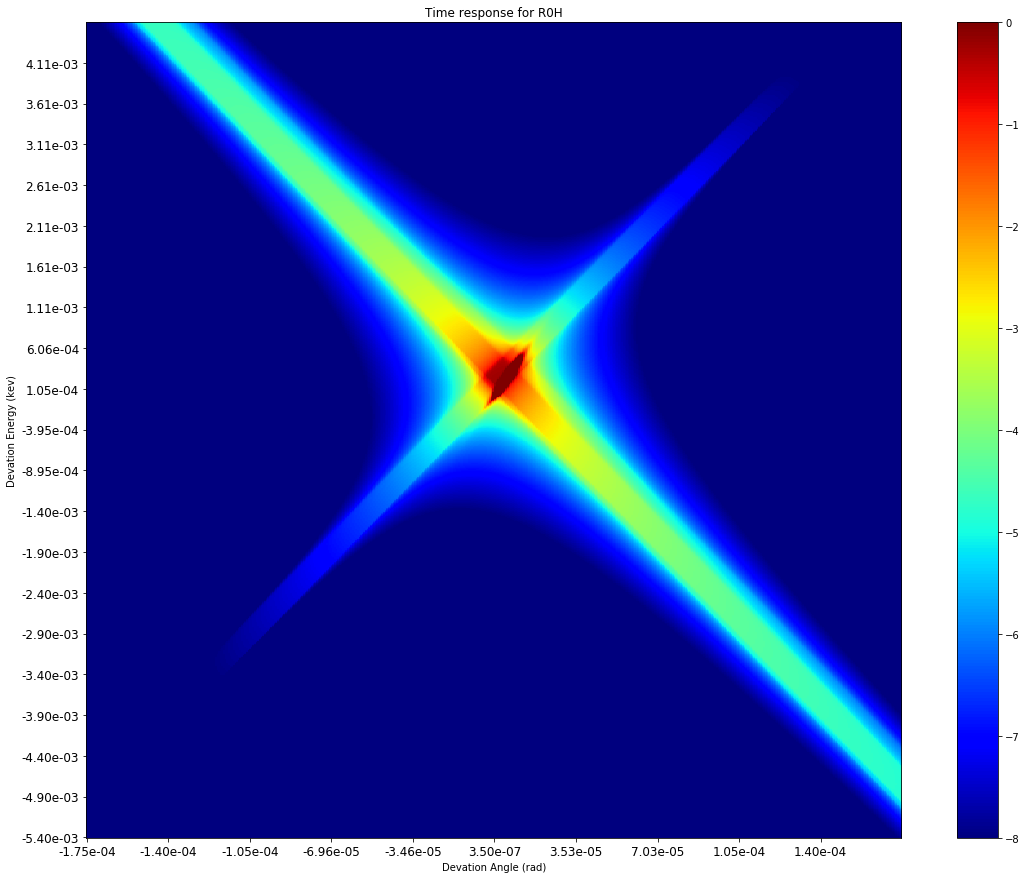

In [12]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(15)
fig.set_figwidth(20)

# Show the average pattern
im = axes.imshow( np.log(np.abs(reflect_pi_2d.T)) + np.abs(y_spectrum_holder_2d.T)/10,
                 vmax= 0.,
                 vmin = -8.,
                 cmap='jet', 
                 origin='lower',
                 aspect = 0.5,
                 )

axes.set_title("Time response for R0H")

axes.set_xticks(np.arange(0, theta_num, step=50))
x_label = ["{:.2e}".format(x) for x in info_dict["theta_array"][::50]]
axes.set_xticklabels(x_label, fontsize=12)

axes.set_yticks(np.arange(0, k_idx_range, step=50))
y_label = ["{:.2e}".format(x) for x in (info_dict["energy_array"][central_start:central_start + k_idx_range:50] 
                                        - energy_center)]
axes.set_yticklabels(y_label, fontsize=12)

axes.set_xlabel("Devation Angle (rad)")
axes.set_ylabel("Devation Energy (kev)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()

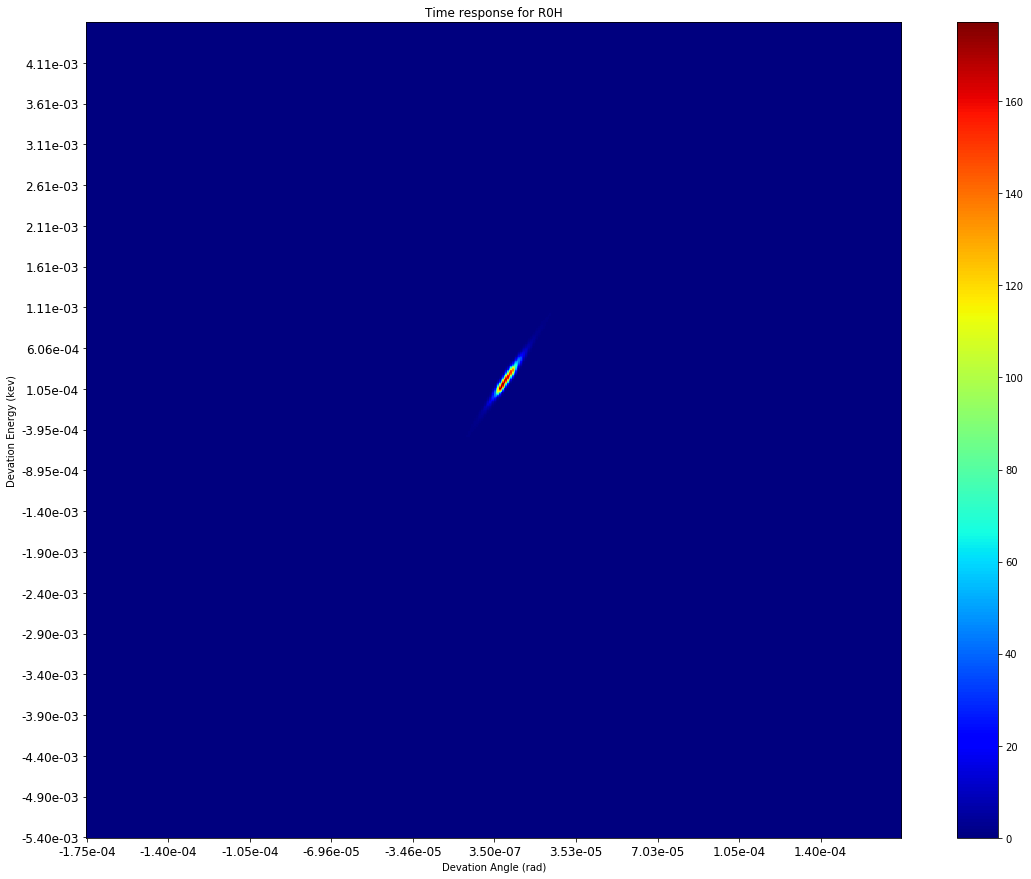

In [13]:
# Set up the canvas
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(15)
fig.set_figwidth(20)

# Show the average pattern
im = axes.imshow( np.abs(y_spectrum_holder_2d.T),
                 #vmax= 0.,
                 #vmin = -8.,
                 cmap='jet', 
                 origin='lower',
                 aspect = 0.5,
                 )

axes.set_title("Time response for R0H")

axes.set_xticks(np.arange(0, theta_num, step=50))
x_label = ["{:.2e}".format(x) for x in info_dict["theta_array"][::50]]
axes.set_xticklabels(x_label, fontsize=12)

axes.set_yticks(np.arange(0, k_idx_range, step=50))
y_label = ["{:.2e}".format(x) for x in (info_dict["energy_array"][central_start:central_start + k_idx_range:50] 
                                        - energy_center)]
axes.set_yticklabels(y_label, fontsize=12)

axes.set_xlabel("Devation Angle (rad)")
axes.set_ylabel("Devation Energy (kev)")
fig.colorbar(im, ax=axes)
# Show the canvas

plt.show()

In [14]:
print("{:.4e}".format(np.sum(np.square(np.abs(y_spectrum_holder_2d)))))

2.3652e+06
